In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
data = pd.read_csv("heart.csv")
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB
None


**Part 1: Exploratory Data Analysis**

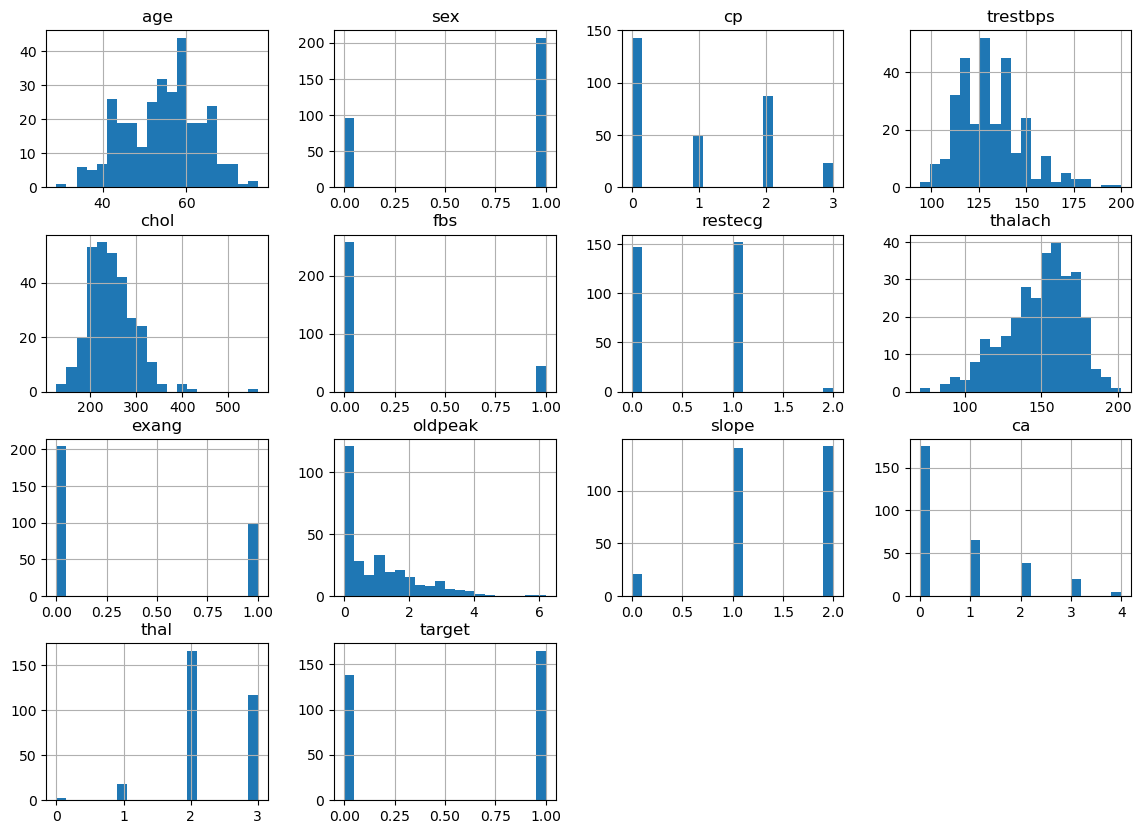

In [24]:
data.hist(bins = 20, figsize = (14, 10))
plt.show()

In [26]:
data.nunique()

age          41
sex           2
cp            4
trestbps     49
chol        152
fbs           2
restecg       3
thalach      91
exang         2
oldpeak      40
slope         3
ca            5
thal          4
target        2
dtype: int64

In [88]:
data.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

sex, cp, fbs, restecg, exang, slope, ca, thal, and target are categorical values
only cp, ca, and thal need to be encoded the rest are in binary
restecg in 0, 1, 2 categories - the 2s not actually outliers can ignore and just scale
no missing values

**Part 2: Split the data**

In [60]:
# stratify split the data
from sklearn.model_selection import train_test_split
training_data, testing_data = train_test_split(data, test_size = 0.2, stratify = data["target"], random_state = 42)
print(f"Percentage of positive targets in training data: {len(training_data[training_data["target"] == 1]) / len(training_data)}")
print(f"Percentage of positive targets in testing data:  {len(testing_data[testing_data["target"] == 1]) / len(testing_data)}")

Percentage of positive targets in training data: 0.5454545454545454
Percentage of positive targets in testing data:  0.5409836065573771


**Part 3: Data Preprocessing**
* Apply log transform to chol and oldpeak
* OneHotEncode cp, restecg, slope, ca, and thal
* MinMaxScale the remaining numerical features

In [96]:
# separate the data
X_train = training_data.drop(columns = "target").copy()
y_train = training_data["target"].copy()
X_test = training_data.drop(columns = "target").copy()
y_test = training_data["target"].copy()

In [115]:
# create preprocessing pipeline
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

log_pipeline = make_pipeline(FunctionTransformer(np.log1p, feature_names_out = "one-to-one"), MinMaxScaler())
cat_pipeline = make_pipeline(OneHotEncoder(handle_unknown = "ignore"))
num_pipeline = make_pipeline(MinMaxScaler())

preprocessing = ColumnTransformer([("log", log_pipeline, ["chol", "oldpeak"]),
                                   ("cat", cat_pipeline, ["cp", "restecg", "slope", "ca", "thal"]),
                                   ("num", num_pipeline, ["age", "trestbps", "thalach"]),
                                   ("binary", num_pipeline, ["sex", "fbs", "exang"])])

**Part 4: Train Models**\
Part 4.1: Logistic Regression

In [117]:
from sklearn.linear_model import LogisticRegression
log_reg = Pipeline([("preprocessing", preprocessing),
                    ("classifier", LogisticRegression(solver = "liblinear", random_state = 42, max_iter = 1000))])
log_reg.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('log',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log1p'>)),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['chol', 'oldpeak']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['cp', 'restecg', 'slope',
                                                   'ca', 'thal']),
                                                 ('num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'trestbps',
                                                   'thalach']),
                                                 ('binary',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['sex', 'fbs', 'exang'])])),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42,
                                    solver='liblinear'))])

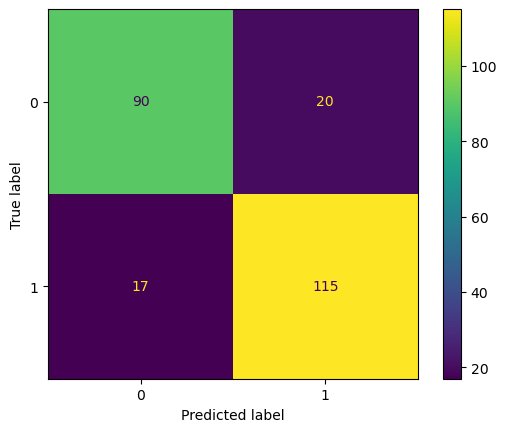

In [126]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict

log_predictions = cross_val_predict(log_reg, X_train, y_train, cv = 5)
log_cm = confusion_matrix(y_train, log_predictions)
log_disp = ConfusionMatrixDisplay(confusion_matrix = log_cm)
log_disp.plot()

Part 4.2: Support Vector Machine (SVM)

In [134]:
from sklearn.svm import SVC
svm = Pipeline([("preprocessing", preprocessing), ("classifier", SVC(kernel = "rbf", C = 1.0))])
svm.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('log',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log1p'>)),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['chol', 'oldpeak']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['cp', 'restecg', 'slope',
                                                   'ca', 'thal']),
                                                 ('num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'trestbps',
                                                   'thalach']),
                                                 ('binary',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['sex', 'fbs', 'exang'])])),
                ('classifier', SVC())])

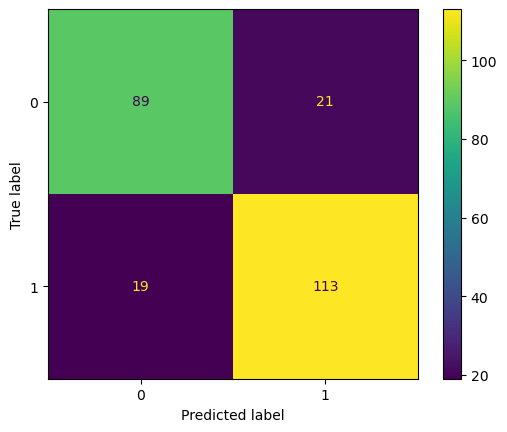

In [136]:
svm_predictions = cross_val_predict(svm, X_train, y_train, cv = 5)
svm_cm = confusion_matrix(y_train, svm_predictions)
svm_disp = ConfusionMatrixDisplay(confusion_matrix = svm_cm)
svm_disp.plot()

Part 4.3: K Nearest Neighbors (KNN)

In [158]:
from sklearn.neighbors import KNeighborsClassifier
knn = Pipeline([("preprocessing", preprocessing), ("classifier", KNeighborsClassifier(n_neighbors = 5))])
knn.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('log',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log1p'>)),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['chol', 'oldpeak']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['cp', 'restecg', 'slope',
                                                   'ca', 'thal']),
                                                 ('num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'trestbps',
                                                   'thalach']),
                                                 ('binary',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['sex', 'fbs', 'exang'])])),
                ('classifier', KNeighborsClassifier())])

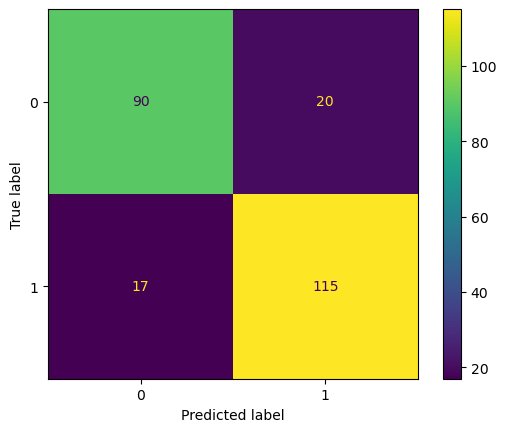

In [160]:
knn_predictions = cross_val_predict(knn, X_train, y_train, cv=5)
knn_cm = confusion_matrix(y_train, knn_predictions)
knn_disp = ConfusionMatrixDisplay(confusion_matrix = knn_cm)
knn_disp.plot()

Part 4.4: Random Forest

In [152]:
from sklearn.ensemble import RandomForestClassifier
forest_class = Pipeline([("preprocessing", preprocessing), ("classifier", RandomForestClassifier(random_state = 42))])
forest_class.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('log',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log1p'>)),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['chol', 'oldpeak']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['cp', 'restecg', 'slope',
                                                   'ca', 'thal']),
                                                 ('num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'trestbps',
                                                   'thalach']),
                                                 ('binary',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['sex', 'fbs', 'exang'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

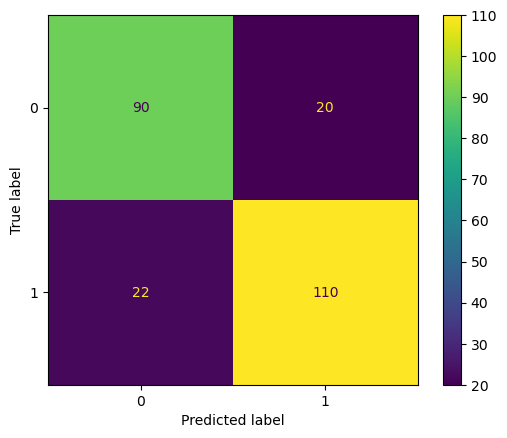

In [156]:
forest_predictions = cross_val_predict(forest_class, X_train, y_train, cv=5)
forest_cm = confusion_matrix(y_train, forest_predictions)
forest_disp = ConfusionMatrixDisplay(confusion_matrix = forest_cm)
forest_disp.plot()

**Part 5: Optimize Model**\
Choose KNN to optimize

In [170]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distributions = {"classifier__n_neighbors": randint(1, 50), "classifier__weights": ["uniform", "distance"], "classifier__p": [1, 2]}
rand_search = RandomizedSearchCV(knn, param_distributions = param_distributions, n_iter = 10, cv = 3, scoring = "accuracy", random_state = 42)
rand_search.fit(X_train, y_train)
rand_search.best_params_

{'classifier__n_neighbors': 19,
 'classifier__p': 1,
 'classifier__weights': 'uniform'}

**Part 6: Test Model**\
I have yet to figure out how to get feature importances out. Might scrap knn

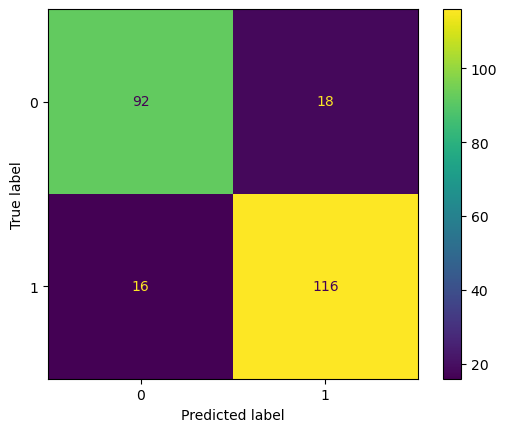

In [179]:
best_knn = rand_search.best_estimator_
knn_predictions = best_knn.predict(X_test)
cm = confusion_matrix(y_test, knn_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()